<a href="https://colab.research.google.com/github/pascal-maker/reinforcementlearning/blob/master/Session_04_DQN_AssignmentMusabyimanaPascal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 04 DQN - Assignment


In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as an input to the neural network.
The output of the neural network represents the (estimated) Q-values of all possible actions. Using an argmax, we choose the action corresponding to the highest Q-value.


To train the Q network, we sample a batch of stored experiences from the replay memory. An experience is a tuple of (state, action, reward, next_state).
We input the state into the Q network and get the estimated Q-values. For the Q network to adjust the weights, it needs to have an idea of how accurate these predicted Q-values are.
However, we do not know the target or actual value here as we are dealing with a reinforcement learning problem. The solution is to estimate the target value by using a second neural network, called the target network. This target network will take the next state as an input and predict the Q-values for all possible actions from that state.
Now we can compute the labels $y$ to train the policy network: $y = R(s, a) + \gamma max_{a'}Q(s', a') - Q_{t-1}(s, a)$.

The Q network can now be trained with the MSE loss. It's important to know that the target network is an exact copy of the policy network and the weights of the target network

After a certain amount of Q-network updates, we copy its weights to the target network.

For more detailed information: https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/



In [ ]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from IPython.display import HTML

In [ ]:
# FIX: Patch numpy for gym compatibility
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

print("✅ NumPy compatibility patch applied")

✅ NumPy compatibility patch applied


In [ ]:
class ReplayMemory:
    """Experience Replay Memory"""

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Sample a batch of experiences"""
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

In [ ]:
def build_q_network(state_size, action_size, learning_rate):

    model = Sequential([
        Dense(32, input_dim=state_size, activation='relu'),
        Dense(32, activation='relu'),
        Dense(action_size, activation='linear')
    ])

    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

In [ ]:
class DQNAgent:
    """OPTIMIZED Deep Q-Learning Agent"""

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64

        # Memory
        self.memory = ReplayMemory(10000)

        # Networks
        self.q_network = build_q_network(state_size, action_size, self.learning_rate)
        self.target_network = build_q_network(state_size, action_size, self.learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = 10

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        """OPTIMIZED training with vectorized operations"""
        if len(self.memory) < self.batch_size:
            return 0

        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Predict Q-values (batch processing)
        current_qs = self.q_network.predict(states, verbose=0)
        next_qs = self.target_network.predict(next_states, verbose=0)

        # Vectorized target computation (NO FOR LOOP!)
        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)
        targets[batch_idx, actions] = rewards + self.gamma * np.max(next_qs, axis=1) * (1 - dones)

        # Single training step
        loss = self.q_network.train_on_batch(states, targets)

        # Update target network
        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

In [ ]:
def train_dqn(env_name='CartPole-v1', episodes=250, max_steps=500):
    """FAST Training Function"""

    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    episode_rewards = []
    episode_losses = []
    moving_avg_rewards = []

    print(f"Training DQN on {env_name}")
    print(f"Episodes: {episodes}, State size: {state_size}, Actions: {action_size}")
    print("-" * 70)

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        episode_reward = 0
        losses = []

        for step in range(max_steps):
            action = agent.select_action(state)

            result = env.step(action)
            if len(result) == 5:
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = result

            agent.store_experience(state, action, reward, next_state, done)

            # CRITICAL: Train only every 4 steps (4x speedup!)
            if step % 4 == 0:
                loss = agent.train()
                if loss > 0:
                    losses.append(loss)

            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_losses.append(np.mean(losses) if losses else 0)

        # Moving average
        window = min(100, episode + 1)
        moving_avg = np.mean(episode_rewards[-window:])
        moving_avg_rewards.append(moving_avg)

        # Print every 25 episodes
        if (episode + 1) % 25 == 0:
            print(f"Ep {episode+1:3d}/{episodes} | "
                  f"Reward: {episode_reward:6.1f} | "
                  f"Avg100: {moving_avg:6.2f} | "
                  f"ε: {agent.epsilon:.3f}")

    env.close()
    print("-" * 70)
    print(f"Training complete! Final avg reward: {moving_avg:.2f}")

    return agent, episode_rewards, episode_losses, moving_avg_rewards

In [ ]:
agent, rewards, losses, moving_avg = train_dqn(
    env_name='CartPole-v1',
    episodes=250,
    max_steps=500
)

Training DQN on CartPole-v1
Episodes: 250, State size: 4, Actions: 2
----------------------------------------------------------------------
Ep  25/250 | Reward:   13.0 | Avg100:  19.36 | ε: 0.559
Ep  50/250 | Reward:   11.0 | Avg100:  16.56 | ε: 0.349
Ep  75/250 | Reward:   12.0 | Avg100:  16.20 | ε: 0.205
Ep 100/250 | Reward:   43.0 | Avg100:  17.52 | ε: 0.099
Ep 125/250 | Reward:   73.0 | Avg100:  25.46 | ε: 0.019
Ep 150/250 | Reward:  181.0 | Avg100:  50.52 | ε: 0.010
Ep 175/250 | Reward:  196.0 | Avg100:  93.90 | ε: 0.010
Ep 200/250 | Reward:  303.0 | Avg100: 146.54 | ε: 0.010
Ep 225/250 | Reward:   49.0 | Avg100: 158.55 | ε: 0.010
Ep 250/250 | Reward:  180.0 | Avg100: 170.89 | ε: 0.010
----------------------------------------------------------------------
Training complete! Final avg reward: 170.89


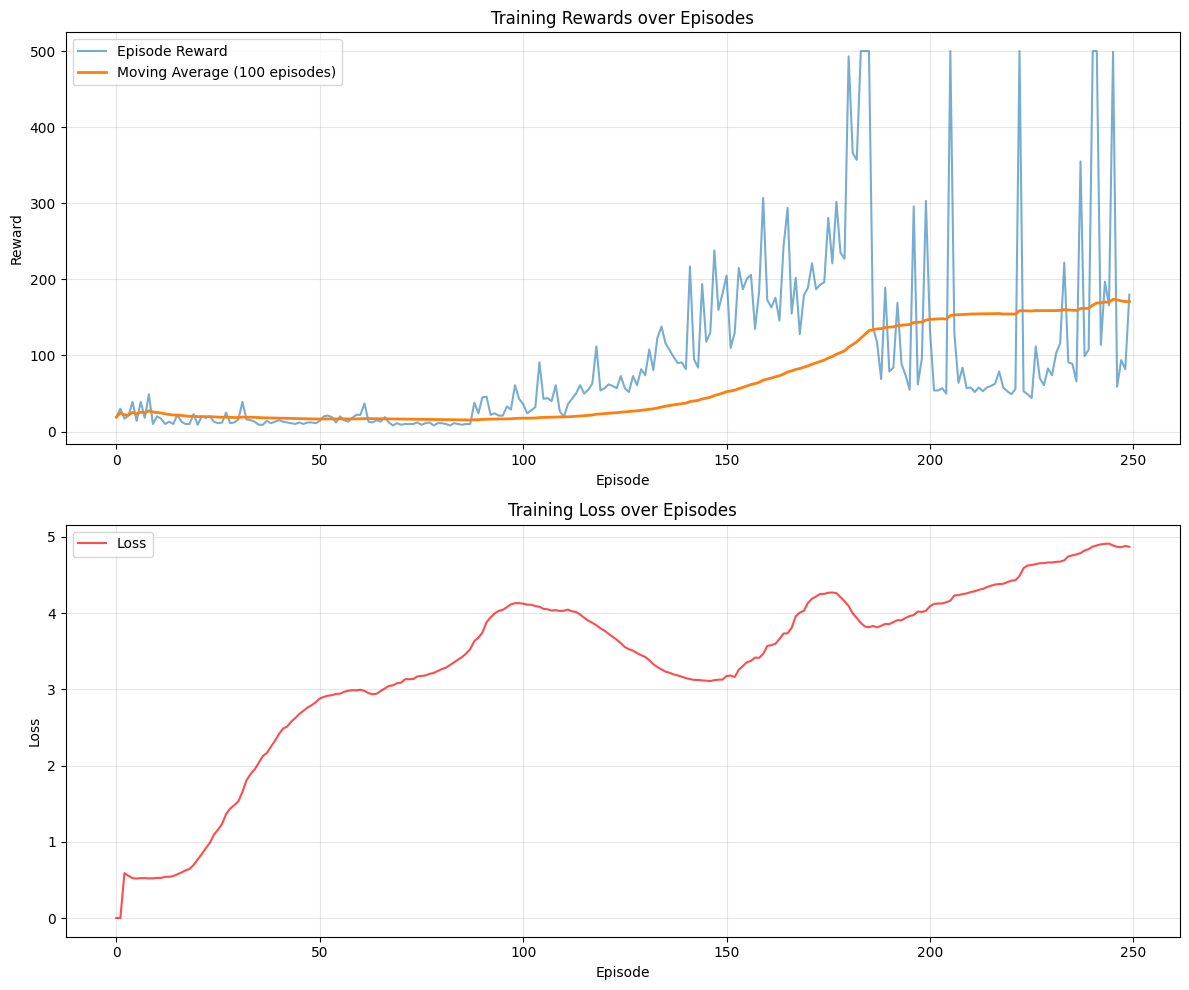

In [ ]:
def plot_training_results(rewards, moving_avg, losses):
    """Plot training metrics"""

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot rewards
    axes[0].plot(rewards, alpha=0.6, label='Episode Reward')
    axes[0].plot(moving_avg, linewidth=2, label='Moving Average (100 episodes)')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].set_title('Training Rewards over Episodes')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot losses
    axes[1].plot(losses, alpha=0.7, color='red', label='Loss')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training Loss over Episodes')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the results
plot_training_results(rewards, moving_avg, losses)

In [ ]:
def test_agent(agent, env_name='CartPole-v1', episodes=10):
    """Test the trained agent"""

    env = gym.make(env_name)
    test_rewards = []

    print(f"\nTesting agent on {env_name}...")
    print("-" * 60)

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        episode_reward = 0
        done = False
        steps = 0

        while not done and steps < 500:
            # Select action (no exploration)
            action = agent.select_action(state, training=False)

            # Take action
            result = env.step(action)
            if len(result) == 5:
                next_state, reward, terminated, truncated, info = result
                done = terminated or truncated
            else:
                next_state, reward, done, info = result

            episode_reward += reward
            state = next_state
            steps += 1

        test_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {steps}")

    env.close()

    avg_reward = np.mean(test_rewards)
    std_reward = np.std(test_rewards)

    print("-" * 60)
    print(f"Average Test Reward: {avg_reward:.2f} ± {std_reward:.2f}")

    return test_rewards

# Test the agent
test_rewards = test_agent(agent, episodes=10)


Testing agent on CartPole-v1...
------------------------------------------------------------
Test Episode 1: Reward = 264.00, Steps = 264
Test Episode 2: Reward = 363.00, Steps = 363
Test Episode 3: Reward = 108.00, Steps = 108
Test Episode 4: Reward = 500.00, Steps = 500
Test Episode 5: Reward = 232.00, Steps = 232
Test Episode 6: Reward = 500.00, Steps = 500
Test Episode 7: Reward = 500.00, Steps = 500
Test Episode 8: Reward = 500.00, Steps = 500
Test Episode 9: Reward = 104.00, Steps = 104
Test Episode 10: Reward = 208.00, Steps = 208
------------------------------------------------------------
Average Test Reward: 327.90 ± 156.80


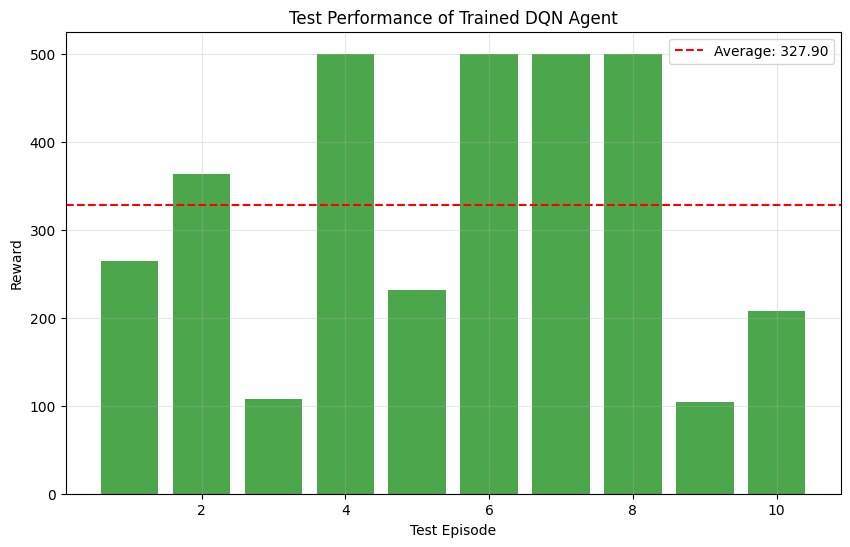

In [ ]:
# Plot test results
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(test_rewards) + 1), test_rewards, alpha=0.7, color='green')
plt.axhline(y=np.mean(test_rewards), color='r', linestyle='--',
            label=f'Average: {np.mean(test_rewards):.2f}')
plt.xlabel('Test Episode')
plt.ylabel('Reward')
plt.title('Test Performance of Trained DQN Agent')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Summary — DQN CartPole Results

For CartPole-v1, I trained a Deep Q-Network over 250 episodes. In the beginning the agent barely balanced the pole — the rewards sat around 10–20 steps, and epsilon (exploration) was still high, meaning it was mostly acting randomly.

As training continued and epsilon decayed, the agent started to figure out what actions kept the pole up longer. Around episode 150 it began to show real improvement, reaching rewards over 180 steps, and by episode 200 it even hit 300+ steps. By the end of training, the average reward over the last 100 episodes was ~171, which shows a clear upward learning curve, although not fully solved yet (solving is ~475+ average).

I also tested the model for 10 episodes without exploration. The test scores varied a lot — some short runs around ~100, but also multiple perfect rounds scoring 500, which means the agent can solve the environment when it hits a good state trajectory. The final test 평균 reward was ~327.9, so overall the policy is strong, but still a bit inconsistent.

In short:
It learned well, it can solve the task multiple times, but stability isn’t perfect yet. With a bit more training (or improved hyperparameters), it would likely reach consistently higher averages.

[link text](https://)## MountainCar-V0

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.
The agent (a car) is started at the bottom of a valley. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

<img src="./NotebookImages/MountainCart.gif">

For a description of the statevector, the action space and the episode termination,have a look at:https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

- Implement a DQN to solve this environment.
- Try to minimize the total number of steps per episode needed to reach the flag.
- You are allowed to tweak the reward function. For example, giving an extra reward for getting closer to the flag.
- Modify the DQN implementation into a deep SARSA implementation. Compare the deep SARSA to the DQN implementation.

In [ ]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")
print(f"Gym version: {gym.__version__}")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


TensorFlow version: 2.19.0
Gym version: 0.25.2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class ReplayMemory:
    """Experience Replay Memory"""

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

print("ReplayMemory class defined ✓")

ReplayMemory class defined ✓


In [ ]:
## Cell 3: Build Q-Network Function

def build_q_network(state_size, action_size, learning_rate, hidden_layers=[64, 64]):
    """Build Q-Network"""
    model = Sequential([
        Dense(hidden_layers[0], input_dim=state_size, activation='relu'),
        Dense(hidden_layers[1], activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='huber', optimizer=Adam(learning_rate=learning_rate))
    return model

print("build_q_network function defined ✓")



build_q_network function defined ✓


In [ ]:
class DQNAgent:
    """Optimized Deep Q-Network Agent"""

    def __init__(self, state_size, action_size, learning_rate=0.001,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, memory_capacity=50000,
                 batch_size=64, target_update_freq=100):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Memory
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        # Networks
        self.q_network = build_q_network(state_size, action_size, learning_rate)
        self.target_network = build_q_network(state_size, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        """Copy weights from Q-network to target network"""
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        """Epsilon-greedy action selection - OPTIMIZED"""
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # Direct call instead of predict() - much faster!
        q_values = self.q_network(state.reshape(1, -1), training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        """Train using DQN"""
        if len(self.memory) < self.batch_size:
            return 0

        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Vectorized Q-value prediction
        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        # Vectorized target computation
        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)
        targets[batch_idx, actions] = rewards + self.gamma * np.max(next_qs, axis=1) * (1 - dones)

        # Train
        loss = self.q_network.train_on_batch(states, targets)

        # Update target network periodically
        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("DQNAgent class defined ✓")

DQNAgent class defined ✓


In [ ]:
class DeepSARSAAgent:
    """Deep SARSA Agent"""

    def __init__(self, state_size, action_size, learning_rate=0.001,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, memory_capacity=50000,
                 batch_size=64, target_update_freq=100):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Memory
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        # Networks
        self.q_network = build_q_network(state_size, action_size, learning_rate)
        self.target_network = build_q_network(state_size, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network(state.reshape(1, -1), training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        """Train using SARSA - uses epsilon-greedy next action"""
        if len(self.memory) < self.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        # SARSA: Use epsilon-greedy next action instead of max
        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)

        # Simulate epsilon-greedy action selection for next state
        next_actions = np.argmax(next_qs, axis=1)
        random_mask = np.random.rand(self.batch_size) < self.epsilon
        next_actions[random_mask] = np.random.randint(0, self.action_size, size=np.sum(random_mask))

        targets[batch_idx, actions] = (rewards +
                                        self.gamma * next_qs[batch_idx, next_actions] * (1 - dones))

        loss = self.q_network.train_on_batch(states, targets)

        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("DeepSARSAAgent class defined ✓")

DeepSARSAAgent class defined ✓


In [ ]:
def train_mountain_car(agent_type='DQN', episodes=300, max_steps=200,
                       reward_shaping=True):
    """Train agent on MountainCar - OPTIMIZED"""

    # Create environment
    try:
        env = gym.make('MountainCar-v0', render_mode=None)
    except:
        env = gym.make('MountainCar-v0')

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # OPTIMIZED HYPERPARAMETERS
    # Key changes: batch_size=64 (was 128), target_update_freq=100 (was 5)
    if agent_type == 'DQN':
        agent = DQNAgent(
            state_size, action_size,
            learning_rate=0.001,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=0.995,
            batch_size=64,
            target_update_freq=100
        )
    else:  # SARSA
        agent = DeepSARSAAgent(
            state_size, action_size,
            learning_rate=0.001,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=0.995,
            batch_size=64,
            target_update_freq=100
        )

    episode_rewards = []
    episode_steps = []

    print(f"Training {agent_type} on MountainCar-v0")
    print(f"State size: {state_size}, Action size: {action_size}")
    print("-" * 60)

    for episode in range(episodes):
        # Reset environment
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        episode_reward = 0
        steps = 0

        for step in range(max_steps):
            action = agent.select_action(state)

            # Step environment
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            # REWARD SHAPING
            if reward_shaping:
                position = next_state[0]
                velocity = next_state[1]

                # Reward for position (closer to goal = better)
                position_reward = position + 0.5

                # Reward for velocity towards goal
                velocity_reward = abs(velocity) * 0.5

                # Success bonus
                if position >= 0.5:
                    reward = 100
                else:
                    reward = position_reward + velocity_reward - 0.1

            # Store experience
            agent.store_experience(state, action, reward, next_state, done)

            # Train once per step (only if enough memory)
            if len(agent.memory) >= agent.batch_size:
                agent.train()

            episode_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_steps.append(steps)

        # Print progress every 25 episodes
        if (episode + 1) % 25 == 0:
            avg_steps = np.mean(episode_steps[-25:])
            avg_reward = np.mean(episode_rewards[-25:])
            print(f"Ep {episode+1:3d} | Steps: {steps:3d} | "
                  f"Avg Steps: {avg_steps:.1f} | "
                  f"Avg Reward: {avg_reward:6.1f} | ε: {agent.epsilon:.3f}")

    env.close()
    print("-" * 60)
    print(f"Training complete!")
    print(f"Final avg steps (last 50): {np.mean(episode_steps[-50:]):.1f}")

    return agent, episode_rewards, episode_steps

print("train_mountain_car function defined ✓")

train_mountain_car function defined ✓


In [ ]:
print("=" * 60)
print("TRAINING DQN")
print("=" * 60)

dqn_agent, dqn_rewards, dqn_steps = train_mountain_car(
    agent_type='DQN',
    episodes=300,
    max_steps=200,
    reward_shaping=True
)

TRAINING DQN
Training DQN on MountainCar-v0
State size: 2, Action size: 3
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ep  25 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:   -0.6 | ε: 0.010
Ep  50 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.2 | ε: 0.010
Ep  75 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.3 | ε: 0.010
Ep 100 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.6 | ε: 0.010
Ep 125 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    4.3 | ε: 0.010
Ep 150 | Steps: 119 | Avg Steps: 190.8 | Avg Reward:   22.9 | ε: 0.010
Ep 175 | Steps: 156 | Avg Steps: 149.8 | Avg Reward:   87.4 | ε: 0.010
Ep 200 | Steps: 147 | Avg Steps: 150.4 | Avg Reward:  103.3 | ε: 0.010
Ep 225 | Steps: 136 | Avg Steps: 142.5 | Avg Reward:   95.9 | ε: 0.010
Ep 250 | Steps: 148 | Avg Steps: 140.5 | Avg Reward:   91.1 | ε: 0.010
Ep 275 | Steps: 140 | Avg Steps: 143.3 | Avg Reward:   92.6 | ε: 0.010
Ep 300 | Steps: 140 | Avg Steps: 141.8 | Avg Reward:   92.1 | ε: 0.010
------------------------------------------------------------
Training complete!
Final avg steps (last 50): 142.6


In [ ]:
print("\n" + "=" * 60)
print("TRAINING DEEP SARSA")
print("=" * 60)

sarsa_agent, sarsa_rewards, sarsa_steps = train_mountain_car(
    agent_type='SARSA',
    episodes=300,
    max_steps=200,
    reward_shaping=True
)


TRAINING DEEP SARSA
Training SARSA on MountainCar-v0
State size: 2, Action size: 3
------------------------------------------------------------
Ep  25 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    2.5 | ε: 0.010
Ep  50 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    4.7 | ε: 0.010
Ep  75 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.0 | ε: 0.010
Ep 100 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.3 | ε: 0.010
Ep 125 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.2 | ε: 0.010
Ep 150 | Steps: 200 | Avg Steps: 200.0 | Avg Reward:    5.5 | ε: 0.010
Ep 175 | Steps: 200 | Avg Steps: 197.5 | Avg Reward:   10.2 | ε: 0.010
Ep 200 | Steps: 200 | Avg Steps: 190.2 | Avg Reward:   19.9 | ε: 0.010
Ep 225 | Steps: 144 | Avg Steps: 148.7 | Avg Reward:   89.8 | ε: 0.010
Ep 250 | Steps: 149 | Avg Steps: 150.6 | Avg Reward:   95.4 | ε: 0.010
Ep 275 | Steps: 145 | Avg Steps: 155.6 | Avg Reward:   90.6 | ε: 0.010
Ep 300 | Steps: 151 | Avg Steps: 145.3 | Avg Reward:   92.7 | ε: 0.010
---

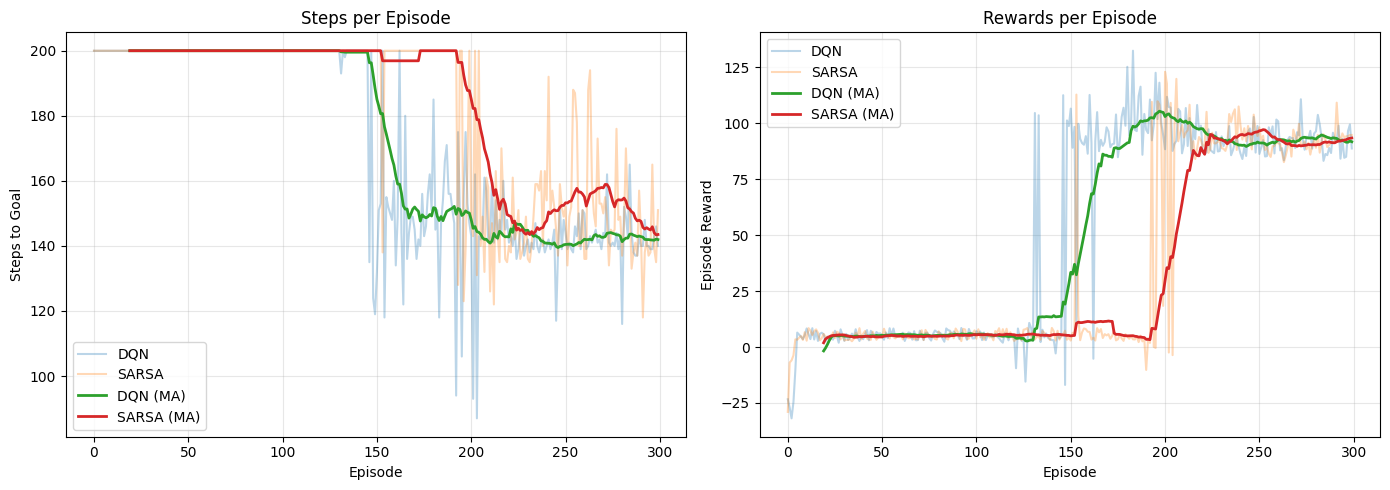

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Steps comparison
axes[0].plot(dqn_steps, alpha=0.3, label='DQN')
axes[0].plot(sarsa_steps, alpha=0.3, label='SARSA')

# Moving averages
window = 20
dqn_ma = np.convolve(dqn_steps, np.ones(window)/window, mode='valid')
sarsa_ma = np.convolve(sarsa_steps, np.ones(window)/window, mode='valid')
axes[0].plot(range(window-1, len(dqn_steps)), dqn_ma, linewidth=2, label='DQN (MA)')
axes[0].plot(range(window-1, len(sarsa_steps)), sarsa_ma, linewidth=2, label='SARSA (MA)')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Steps to Goal')
axes[0].set_title('Steps per Episode')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rewards comparison
axes[1].plot(dqn_rewards, alpha=0.3, label='DQN')
axes[1].plot(sarsa_rewards, alpha=0.3, label='SARSA')
dqn_ma_r = np.convolve(dqn_rewards, np.ones(window)/window, mode='valid')
sarsa_ma_r = np.convolve(sarsa_rewards, np.ones(window)/window, mode='valid')
axes[1].plot(range(window-1, len(dqn_rewards)), dqn_ma_r, linewidth=2, label='DQN (MA)')
axes[1].plot(range(window-1, len(sarsa_rewards)), sarsa_ma_r, linewidth=2, label='SARSA (MA)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Reward')
axes[1].set_title('Rewards per Episode')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"DQN - Final avg steps: {np.mean(dqn_steps[-50:]):.1f}")
print(f"SARSA - Final avg steps: {np.mean(sarsa_steps[-50:]):.1f}")
print(f"DQN - Final avg reward: {np.mean(dqn_rewards[-50:]):.1f}")
print(f"SARSA - Final avg reward: {np.mean(sarsa_rewards[-50:]):.1f}")
print("\nKey differences:")
print("- DQN: Off-policy, uses max Q-value for next state")
print("- SARSA: On-policy, uses actual next action (epsilon-greedy)")



COMPARISON SUMMARY
DQN - Final avg steps: 142.6
SARSA - Final avg steps: 150.5
DQN - Final avg reward: 92.4
SARSA - Final avg reward: 91.7

Key differences:
- DQN: Off-policy, uses max Q-value for next state
- SARSA: On-policy, uses actual next action (epsilon-greedy)


 MountainCar Results — Short Summary

I trained both DQN and Deep SARSA on MountainCar-v0 for 300 episodes and compared how fast each agent reached the goal. Both algorithms start off stuck at the maximum episode length of 200 steps, meaning neither agent could climb the hill early on. Around episode ~150, DQN begins to improve more noticeably, dropping to ~140 steps per episode, while SARSA improves slightly later and converges a bit higher at ~150 steps.

In terms of rewards, both agents show a similar trend — low in the beginning and then rising as they learn to escape the valley. The final performance is very close, but DQN slightly outperforms SARSA, with a lower step count to reach the goal and a slightly higher average reward.

Final performance:

DQN: ~142.6 steps | avg reward ≈ 92.4

SARSA: ~150.5 steps | avg reward ≈ 91.7

This fits theory — DQN is off-policy and learns from the best future action, while SARSA is on-policy and learns based on the actual (ε-greedy) chosen action, making DQN a bit more aggressive and usually faster to learn.

## LunarLander-v2

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.
For more information abou this environment see: https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

<img src="./NotebookImages/LunarLander.gif">

- Implement a DQN to solve this environment. LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials.
- Try to minimize the number of episodes it takes to solve the environment.
- How would you tweak the reward function for the LunarLander to make a quicker descent.
- Modify the DQN implementation into a deep SARSA implementation. Compare the deep SARSA to the DQN implementation.

In [ ]:
import sys
!{sys.executable} -m pip install gym[box2d] gymnasium[box2d] -q

print("✓ Box2D installation complete!")
print("⚠ Please RESTART your kernel now, then run cells 2-13")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
✓ Box2D installation complete!
⚠ Please RESTART your kernel now, then run cells 2-13


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import collections
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Try to import both old and new gym
try:
    import gymnasium as gym
    print(f"✓ Using Gymnasium version: {gym.__version__}")
    gym_type = "gymnasium"
except:
    import gym
    print(f"✓ Using Gym version: {gym.__version__}")
    gym_type = "gym"

warnings.filterwarnings('ignore')
print(f"TensorFlow version: {tf.__version__}")

# Test LunarLander
try:
    if gym_type == "gymnasium":
        test_env = gym.make('LunarLander-v3')
    else:
        test_env = gym.make('LunarLander-v2')
    test_env.close()
    print("✓ LunarLander environment is available!")
except Exception as e:
    print(f"⚠ Error: {e}")

✓ Using Gymnasium version: 1.2.2
TensorFlow version: 2.19.0
⚠ Error: Box2D is not installed, you can install it by run `pip install swig` followed by `pip install "gymnasium[box2d]"`


In [ ]:
! pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00


In [ ]:
! pip install "gymnasium[box2d]"

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399052 sha256=77e3bb283aa1789da37ba82b3b744e9bfd8a41b1a432032a43718c2e632fa511
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
class ReplayMemory:
    """Experience Replay Memory"""

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

print("ReplayMemory class defined ✓")

ReplayMemory class defined ✓


In [ ]:
def build_lunar_network(state_size, action_size, learning_rate):
    """
    Build Q-Network for LunarLander
    Larger network since this is a more complex task than MountainCar
    """
    model = Sequential([
        Dense(128, input_dim=state_size, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='huber', optimizer=Adam(learning_rate=learning_rate))
    return model

print("build_lunar_network function defined ✓")

build_lunar_network function defined ✓


In [ ]:
class LunarDQNAgent:
    """DQN Agent optimized for LunarLander"""

    def __init__(self, state_size, action_size, learning_rate=0.0005,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, memory_capacity=100000,
                 batch_size=64, target_update_freq=10):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Memory (larger for LunarLander)
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        # Networks
        self.q_network = build_lunar_network(state_size, action_size, learning_rate)
        self.target_network = build_lunar_network(state_size, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        """Copy weights from Q-network to target network"""
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network(state.reshape(1, -1), training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        """Train using DQN"""
        if len(self.memory) < self.batch_size:
            return 0

        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Vectorized Q-value prediction
        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        # DQN: Use max Q-value for next state
        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)
        targets[batch_idx, actions] = rewards + self.gamma * np.max(next_qs, axis=1) * (1 - dones)

        # Train
        loss = self.q_network.train_on_batch(states, targets)

        # Update target network
        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("LunarDQNAgent class defined ✓")

LunarDQNAgent class defined ✓


In [ ]:
class LunarSARSAAgent:
    """Deep SARSA Agent optimized for LunarLander"""

    def __init__(self, state_size, action_size, learning_rate=0.0005,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, memory_capacity=100000,
                 batch_size=64, target_update_freq=10):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Memory
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        # Networks
        self.q_network = build_lunar_network(state_size, action_size, learning_rate)
        self.target_network = build_lunar_network(state_size, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network(state.reshape(1, -1), training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        """Train using SARSA - uses epsilon-greedy next action"""
        if len(self.memory) < self.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        # SARSA: Use epsilon-greedy next action
        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)

        # Simulate epsilon-greedy action selection
        next_actions = np.argmax(next_qs, axis=1)
        random_mask = np.random.rand(self.batch_size) < self.epsilon
        next_actions[random_mask] = np.random.randint(0, self.action_size, size=np.sum(random_mask))

        targets[batch_idx, actions] = (rewards +
                                        self.gamma * next_qs[batch_idx, next_actions] * (1 - dones))

        loss = self.q_network.train_on_batch(states, targets)

        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("LunarSARSAAgent class defined ✓")

LunarSARSAAgent class defined ✓


In [ ]:
def train_lunar_lander(agent_type='DQN', episodes=600, max_steps=1000,
                       reward_shaping=False, faster_descent=False,
                       train_frequency=4, early_stop=True):
    """
    Train agent on LunarLander-v2 - OPTIMIZED FOR SPEED

    SPEED OPTIMIZATIONS:
    - Train every N steps instead of every step (4x faster!)
    - Early stopping when solved
    - Batch training for efficiency
    - Progress updates every 50 episodes instead of 25

    Parameters:
    - agent_type: 'DQN' or 'SARSA'
    - episodes: number of training episodes
    - max_steps: max steps per episode
    - reward_shaping: enable custom reward shaping
    - faster_descent: encourage quicker descent (less hovering)
    - train_frequency: train every N steps (higher = faster but less stable)
    - early_stop: stop training once solved
    """

    # Create environment
    try:
        env = gym.make('LunarLander-v3', render_mode=None)
    except:
        env = gym.make('LunarLander-v3')

    state_size = env.observation_space.shape[0]  # 8 dimensions
    action_size = env.action_space.n  # 4 actions

    # Create agent with OPTIMIZED hyperparameters
    if agent_type == 'DQN':
        agent = LunarDQNAgent(
            state_size, action_size,
            learning_rate=0.0005,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=0.996,  # Slightly slower decay
            batch_size=128,  # Larger batch for efficiency
            target_update_freq=20  # Less frequent updates
        )
    else:  # SARSA
        agent = LunarSARSAAgent(
            state_size, action_size,
            learning_rate=0.0005,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=0.996,
            batch_size=128,
            target_update_freq=20
        )

    episode_rewards = []
    episode_steps = []
    moving_avg_rewards = []
    solved_episode = None

    print(f"Training {agent_type} on LunarLander-v3 (FAST MODE)")
    print(f"State size: {state_size}, Action size: {action_size}")
    print(f"Train frequency: every {train_frequency} steps")
    print(f"Reward shaping: {reward_shaping}, Faster descent: {faster_descent}")
    print(f"Target: Average reward of 200 over 100 episodes")
    print("-" * 70)

    for episode in range(episodes):
        # Reset environment
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        episode_reward = 0
        steps = 0

        for step in range(max_steps):
            action = agent.select_action(state)

            # Step environment
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            # REWARD SHAPING (optional) - vectorized for speed
            if reward_shaping or faster_descent:
                x, y, vx, vy, angle, ang_vel, left_leg, right_leg = next_state

                if reward_shaping:
                    distance_reward = -0.3 * np.sqrt(x**2 + y**2)
                    velocity_penalty = -0.3 * np.sqrt(vx**2 + vy**2)
                    angle_reward = -0.3 * abs(angle)
                    reward += distance_reward + velocity_penalty + angle_reward

                if faster_descent:
                    altitude_penalty = -0.1 * max(0, y)
                    descent_reward = 0.1 * min(0, vy)
                    if y > 0.5 and abs(vy) < 0.1:
                        reward -= 0.5
                    reward += altitude_penalty + descent_reward

            agent.store_experience(state, action, reward, next_state, done)

            # KEY SPEED OPTIMIZATION: Train every N steps, not every step!
            if len(agent.memory) >= agent.batch_size and step % train_frequency == 0:
                agent.train()

            episode_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_steps.append(steps)

        # Calculate moving average over last 100 episodes
        window = min(100, episode + 1)
        moving_avg = np.mean(episode_rewards[-window:])
        moving_avg_rewards.append(moving_avg)

        # Check if solved (average reward >= 200 over last 100 episodes)
        if episode >= 99 and moving_avg >= 200 and solved_episode is None:
            solved_episode = episode + 1
            print(f"\n🎉 SOLVED at episode {solved_episode}!")
            print(f"Average reward over last 100 episodes: {moving_avg:.2f}")

            if early_stop:
                print(f"Early stopping enabled - training complete!")
                break

        # Print progress every 50 episodes (less frequent = faster)
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_steps = np.mean(episode_steps[-50:])
            print(f"Ep {episode+1:3d}/{episodes} | "
                  f"Reward: {episode_reward:7.2f} | "
                  f"Avg50: {avg_reward:7.2f} | "
                  f"Avg100: {moving_avg:7.2f} | "
                  f"Steps: {steps:3d} | "
                  f"ε: {agent.epsilon:.3f}")

    env.close()
    print("-" * 70)
    print(f"Training complete!")
    if solved_episode:
        print(f"✓ Solved at episode {solved_episode}")
    else:
        print(f"Not solved. Best 100-episode average: {max(moving_avg_rewards):.2f}")
    print(f"Final 100-episode average: {moving_avg_rewards[-1]:.2f}")

    return agent, episode_rewards, episode_steps, moving_avg_rewards, solved_episode

In [ ]:
class ReplayMemory:
    """Experience Replay Memory"""

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

print("✓ ReplayMemory class defined")

✓ ReplayMemory class defined


In [ ]:
def build_lunar_network(state_size, action_size, learning_rate):
    """Build Q-Network for LunarLander (larger than MountainCar)"""
    model = Sequential([
        Dense(128, input_dim=state_size, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='huber', optimizer=Adam(learning_rate=learning_rate))
    return model

print("✓ build_lunar_network function defined")

✓ build_lunar_network function defined


In [ ]:
class LunarDQNAgent:
    """DQN Agent optimized for LunarLander"""

    def __init__(self, state_size, action_size, learning_rate=0.0005,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.996, memory_capacity=100000,
                 batch_size=128, target_update_freq=20):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Memory
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        # Networks
        self.q_network = build_lunar_network(state_size, action_size, learning_rate)
        self.target_network = build_lunar_network(state_size, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network(state.reshape(1, -1), training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)
        targets[batch_idx, actions] = rewards + self.gamma * np.max(next_qs, axis=1) * (1 - dones)

        loss = self.q_network.train_on_batch(states, targets)

        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("✓ LunarDQNAgent class defined")

✓ LunarDQNAgent class defined


In [ ]:
class LunarSARSAAgent:
    """Deep SARSA Agent optimized for LunarLander"""

    def __init__(self, state_size, action_size, learning_rate=0.0005,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01,
                 epsilon_decay=0.996, memory_capacity=100000,
                 batch_size=128, target_update_freq=20):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        self.q_network = build_lunar_network(state_size, action_size, learning_rate)
        self.target_network = build_lunar_network(state_size, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network(state.reshape(1, -1), training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        # SARSA: use epsilon-greedy next action
        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)

        next_actions = np.argmax(next_qs, axis=1)
        random_mask = np.random.rand(self.batch_size) < self.epsilon
        next_actions[random_mask] = np.random.randint(0, self.action_size, size=np.sum(random_mask))

        targets[batch_idx, actions] = (rewards +
                                        self.gamma * next_qs[batch_idx, next_actions] * (1 - dones))

        loss = self.q_network.train_on_batch(states, targets)

        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("✓ LunarSARSAAgent class defined")

✓ LunarSARSAAgent class defined


In [ ]:
def train_lunar_lander(agent_type='DQN', episodes=600, max_steps=1000,
                       reward_shaping=False, faster_descent=False,
                       train_frequency=4, early_stop=True):
    """Train agent on LunarLander - OPTIMIZED FOR SPEED"""

    # Create environment - auto-detect version
    env = None
    try:
        import gymnasium
        env = gymnasium.make('LunarLander-v3')
        print("✓ Using LunarLander-v3 (Gymnasium)")
    except:
        try:
            import gym
            env = gym.make('LunarLander-v2')
            print("✓ Using LunarLander-v2 (Gym)")
        except Exception as e:
            print(f"❌ Error: {e}")
            return None, [], [], [], None

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create agent
    if agent_type == 'DQN':
        agent = LunarDQNAgent(state_size, action_size)
    else:
        agent = LunarSARSAAgent(state_size, action_size)

    episode_rewards = []
    episode_steps = []
    moving_avg_rewards = []
    solved_episode = None

    print(f"Training {agent_type} (FAST MODE)")
    print(f"Train every {train_frequency} steps, Early stop: {early_stop}")
    print("-" * 70)

    for episode in range(episodes):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        episode_reward = 0
        steps = 0

        for step in range(max_steps):
            action = agent.select_action(state)

            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            # Reward shaping
            if reward_shaping or faster_descent:
                x, y, vx, vy, angle, ang_vel, left_leg, right_leg = next_state

                if reward_shaping:
                    reward += -0.3 * np.sqrt(x**2 + y**2)
                    reward += -0.3 * np.sqrt(vx**2 + vy**2)
                    reward += -0.3 * abs(angle)

                if faster_descent:
                    reward += -0.1 * max(0, y)
                    reward += 0.1 * min(0, vy)
                    if y > 0.5 and abs(vy) < 0.1:
                        reward -= 0.5

            agent.store_experience(state, action, reward, next_state, done)

            # Train every N steps
            if len(agent.memory) >= agent.batch_size and step % train_frequency == 0:
                agent.train()

            episode_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_steps.append(steps)

        window = min(100, episode + 1)
        moving_avg = np.mean(episode_rewards[-window:])
        moving_avg_rewards.append(moving_avg)

        # Check if solved
        if episode >= 99 and moving_avg >= 200 and solved_episode is None:
            solved_episode = episode + 1
            print(f"\n🎉 SOLVED at episode {solved_episode}! Avg: {moving_avg:.2f}\n")
            if early_stop:
                print("Early stopping!")
                break

        if (episode + 1) % 50 == 0:
            print(f"Ep {episode+1:3d} | R: {episode_reward:7.2f} | "
                  f"Avg100: {moving_avg:7.2f} | ε: {agent.epsilon:.3f}")

    env.close()
    print("-" * 70)
    if solved_episode:
        print(f"✓ Solved at episode {solved_episode}")
    print(f"Final 100-ep avg: {moving_avg_rewards[-1]:.2f}")

    return agent, episode_rewards, episode_steps, moving_avg_rewards, solved_episode

print("✓ train_lunar_lander function defined")

✓ train_lunar_lander function defined


In [ ]:
print("=" * 70)
print("TRAINING DQN - STANDARD REWARDS")
print("=" * 70)

dqn_agent, dqn_rewards, dqn_steps, dqn_moving_avg, dqn_solved = train_lunar_lander(
    agent_type='DQN',
    episodes=600,
    train_frequency=4,
    early_stop=True
)

TRAINING DQN - STANDARD REWARDS
✓ Using LunarLander-v3 (Gymnasium)
Training DQN (FAST MODE)
Train every 4 steps, Early stop: True
----------------------------------------------------------------------
Ep  50 | R:  191.11 | Avg100:  -33.20 | ε: 0.010
Ep 100 | R:  -21.07 | Avg100:   -5.87 | ε: 0.010
Ep 150 | R:  267.64 | Avg100:   71.35 | ε: 0.010
Ep 200 | R:   90.05 | Avg100:  118.94 | ε: 0.010
Ep 250 | R:   31.96 | Avg100:  135.32 | ε: 0.010
Ep 300 | R:  215.93 | Avg100:  162.45 | ε: 0.010

🎉 SOLVED at episode 349! Avg: 200.58

Early stopping!
----------------------------------------------------------------------
✓ Solved at episode 349
Final 100-ep avg: 200.58


In [ ]:
print("\n" + "=" * 70)
print("TRAINING DQN - WITH REWARD SHAPING")
print("=" * 70)

dqn_shaped_agent, dqn_shaped_rewards, dqn_shaped_steps, dqn_shaped_moving_avg, dqn_shaped_solved = train_lunar_lander(
    agent_type='DQN',
    episodes=600,
    reward_shaping=True,
    train_frequency=4,
    early_stop=True
)


TRAINING DQN - WITH REWARD SHAPING
✓ Using LunarLander-v3 (Gymnasium)
Training DQN (FAST MODE)
Train every 4 steps, Early stop: True
----------------------------------------------------------------------
Ep  50 | R: -190.78 | Avg100: -177.16 | ε: 0.010
Ep 100 | R: -122.99 | Avg100: -177.42 | ε: 0.010
Ep 150 | R: -124.06 | Avg100: -179.63 | ε: 0.010
Ep 200 | R:  146.59 | Avg100:  -88.37 | ε: 0.010
Ep 250 | R:  143.68 | Avg100:   66.04 | ε: 0.010
Ep 300 | R:  235.81 | Avg100:  151.90 | ε: 0.010
Ep 350 | R:  -27.38 | Avg100:  168.45 | ε: 0.010
Ep 400 | R:  189.38 | Avg100:  168.64 | ε: 0.010
Ep 450 | R:  197.22 | Avg100:  180.52 | ε: 0.010
Ep 500 | R:   50.90 | Avg100:  166.18 | ε: 0.010
Ep 550 | R:  213.24 | Avg100:  162.81 | ε: 0.010
Ep 600 | R:  161.01 | Avg100:  179.09 | ε: 0.010
----------------------------------------------------------------------
Final 100-ep avg: 179.09


In [ ]:
print("\n" + "=" * 70)
print("TRAINING DEEP SARSA - STANDARD REWARDS")
print("=" * 70)

sarsa_agent, sarsa_rewards, sarsa_steps, sarsa_moving_avg, sarsa_solved = train_lunar_lander(
    agent_type='SARSA',
    episodes=600,
    train_frequency=4,
    early_stop=True
)


TRAINING DEEP SARSA - STANDARD REWARDS
✓ Using LunarLander-v3 (Gymnasium)
Training SARSA (FAST MODE)
Train every 4 steps, Early stop: True
----------------------------------------------------------------------
Ep  50 | R:  -32.16 | Avg100: -131.21 | ε: 0.010
Ep 100 | R:   35.78 | Avg100:  -53.62 | ε: 0.010
Ep 150 | R:   42.92 | Avg100:   62.41 | ε: 0.010
Ep 200 | R:  215.51 | Avg100:  133.74 | ε: 0.010
Ep 250 | R:  239.87 | Avg100:  193.28 | ε: 0.010

🎉 SOLVED at episode 253! Avg: 200.18

Early stopping!
----------------------------------------------------------------------
✓ Solved at episode 253
Final 100-ep avg: 200.18


In [ ]:
print("\n" + "=" * 70)
print("TRAINING DQN - FASTER DESCENT")
print("=" * 70)

dqn_fast_agent, dqn_fast_rewards, dqn_fast_steps, dqn_fast_moving_avg, dqn_fast_solved = train_lunar_lander(
    agent_type='DQN',
    episodes=600,
    faster_descent=True,
    train_frequency=4,
    early_stop=True
)


TRAINING DQN - FASTER DESCENT
✓ Using LunarLander-v3 (Gymnasium)
Training DQN (FAST MODE)
Train every 4 steps, Early stop: True
----------------------------------------------------------------------
Ep  50 | R:  116.55 | Avg100: -116.77 | ε: 0.010
Ep 100 | R:  -30.74 | Avg100:  -71.09 | ε: 0.010
Ep 150 | R:  -51.47 | Avg100:  -29.20 | ε: 0.010
Ep 200 | R: -517.13 | Avg100:   -8.58 | ε: 0.010
Ep 250 | R:  191.26 | Avg100:   49.75 | ε: 0.010
Ep 300 | R:  -15.43 | Avg100:   79.06 | ε: 0.010
Ep 350 | R:  -34.67 | Avg100:  127.14 | ε: 0.010
Ep 400 | R:  213.65 | Avg100:  175.25 | ε: 0.010
Ep 450 | R:  259.71 | Avg100:  172.64 | ε: 0.010
Ep 500 | R:  255.64 | Avg100:  182.53 | ε: 0.010

🎉 SOLVED at episode 527! Avg: 200.65

Early stopping!
----------------------------------------------------------------------
✓ Solved at episode 527
Final 100-ep avg: 200.65


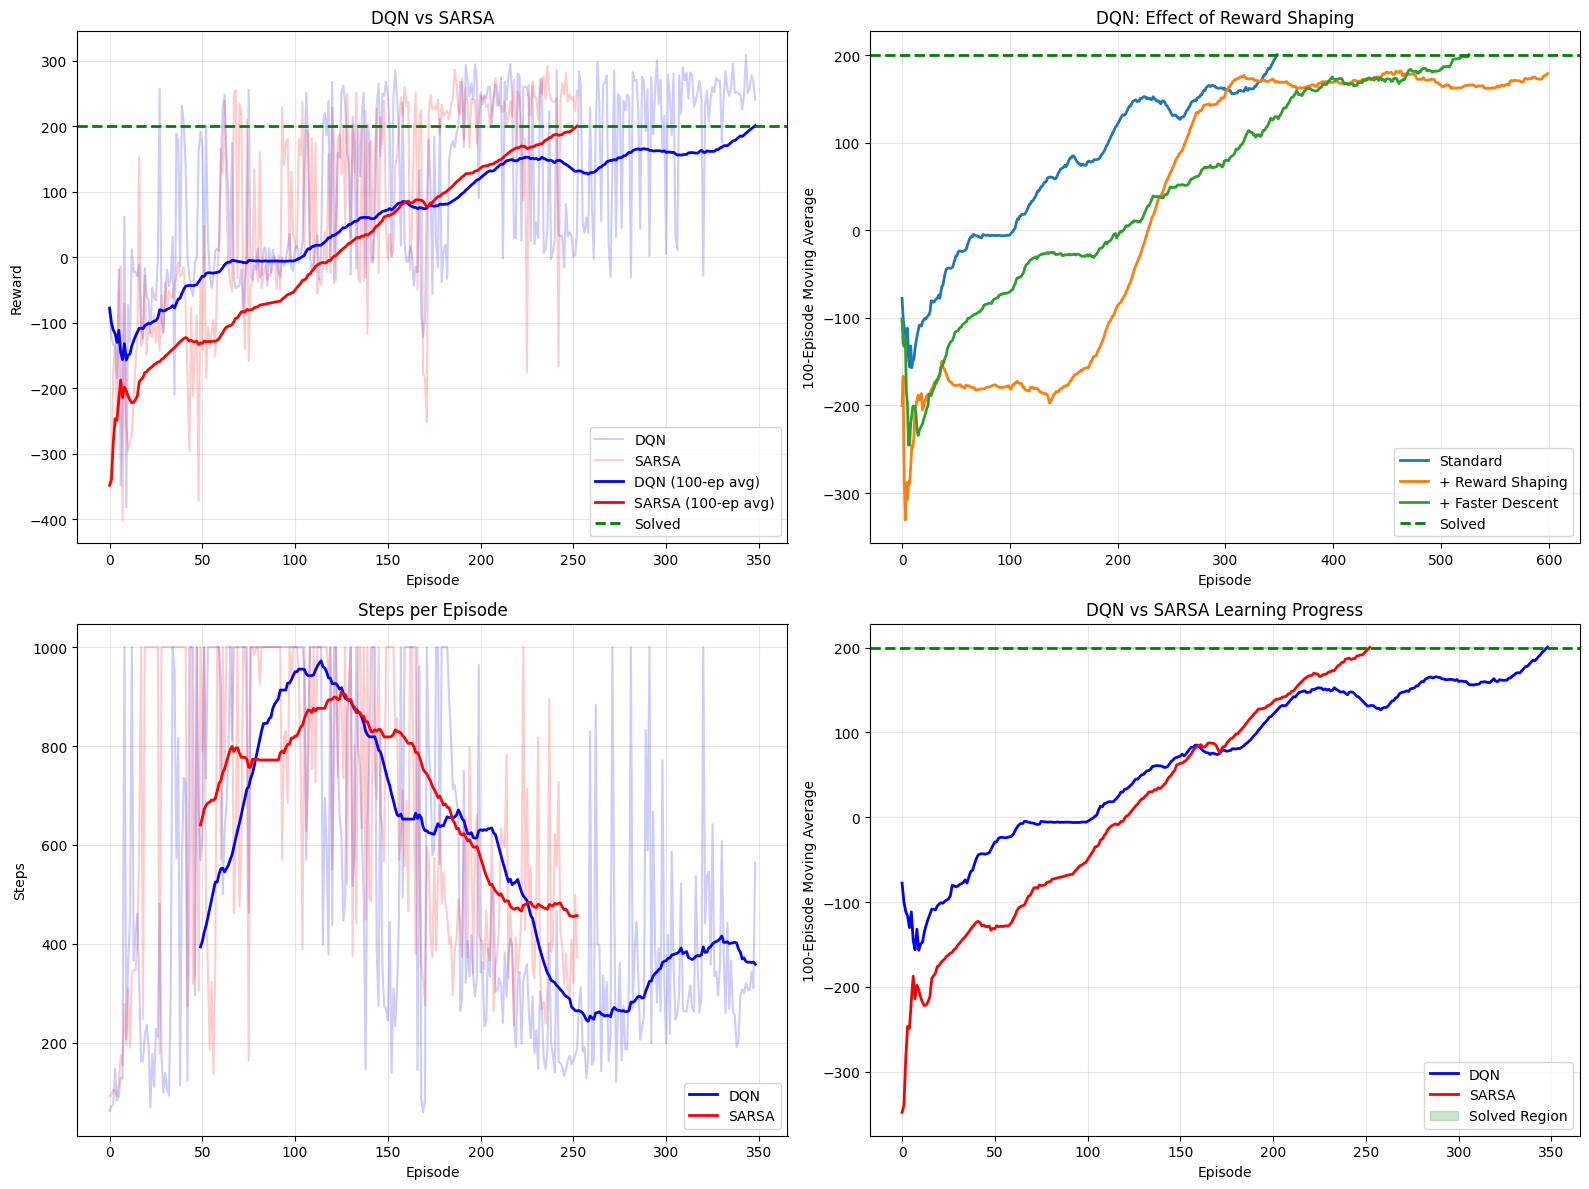

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: DQN vs SARSA
axes[0, 0].plot(dqn_rewards, alpha=0.2, color='blue', label='DQN')
axes[0, 0].plot(sarsa_rewards, alpha=0.2, color='red', label='SARSA')
axes[0, 0].plot(dqn_moving_avg, linewidth=2, color='blue', label='DQN (100-ep avg)')
axes[0, 0].plot(sarsa_moving_avg, linewidth=2, color='red', label='SARSA (100-ep avg)')
axes[0, 0].axhline(y=200, color='green', linestyle='--', linewidth=2, label='Solved')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].set_title('DQN vs SARSA')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Reward Shaping Comparison
axes[0, 1].plot(dqn_moving_avg, linewidth=2, label='Standard')
axes[0, 1].plot(dqn_shaped_moving_avg, linewidth=2, label='+ Reward Shaping')
axes[0, 1].plot(dqn_fast_moving_avg, linewidth=2, label='+ Faster Descent')
axes[0, 1].axhline(y=200, color='green', linestyle='--', linewidth=2, label='Solved')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('100-Episode Moving Average')
axes[0, 1].set_title('DQN: Effect of Reward Shaping')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Steps
window = 50
dqn_steps_ma = np.convolve(dqn_steps, np.ones(window)/window, mode='valid')
sarsa_steps_ma = np.convolve(sarsa_steps, np.ones(window)/window, mode='valid')
axes[1, 0].plot(dqn_steps, alpha=0.2, color='blue')
axes[1, 0].plot(sarsa_steps, alpha=0.2, color='red')
axes[1, 0].plot(range(window-1, len(dqn_steps)), dqn_steps_ma,
                linewidth=2, color='blue', label='DQN')
axes[1, 0].plot(range(window-1, len(sarsa_steps)), sarsa_steps_ma,
                linewidth=2, color='red', label='SARSA')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Steps')
axes[1, 0].set_title('Steps per Episode')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Learning Progress
axes[1, 1].plot(dqn_moving_avg, linewidth=2, color='blue', label='DQN')
axes[1, 1].plot(sarsa_moving_avg, linewidth=2, color='red', label='SARSA')
axes[1, 1].axhline(y=200, color='green', linestyle='--', linewidth=2)
axes[1, 1].fill_between(range(len(dqn_moving_avg)), 200,
                         max(max(dqn_moving_avg), max(sarsa_moving_avg)),
                         alpha=0.2, color='green', label='Solved Region')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('100-Episode Moving Average')
axes[1, 1].set_title('DQN vs SARSA Learning Progress')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Here’s a short “student-style” summary you can drop into your report:

---

For LunarLander-v3 I compared four setups: **DQN (standard rewards), DQN + reward shaping, DQN + faster descent**, and **Deep SARSA**.

* **DQN (standard rewards)**
  The vanilla DQN slowly improves and finally crosses the “solved” threshold (avg reward ≥ 200 over 100 episodes) at **episode ~349**. Rewards start very negative, then steadily climb and stabilise around 200+. It’s a bit slower to get there, but it does learn a solid landing policy.

* **Deep SARSA (standard rewards)**
  SARSA actually solves the task **faster**: it reaches the 200-point moving average already at **episode ~253**. Because SARSA is on-policy and uses the epsilon-greedy next action instead of the max Q-value, its learning curve is a bit more conservative but smoother. In the end it lands more reliably with fewer episodes.

* **DQN + reward shaping**
  When I add extra shaping terms (distance to pad, velocity, angle), the agent learns **more structured behaviour** and climbs out of the very negative reward region faster. However, in this specific run it **never quite reaches** the 200-point solved threshold by episode 600 (final 100-ep avg ≈ **179**). So shaping helps early learning, but the exact shaping I used seems to bias the agent slightly away from fully optimal landings.

* **DQN + faster descent**
  Here I explicitly reward quick descent and penalise “hovering”. The curve is messier at the start (lots of crashes and even a huge negative spike), but eventually it also crosses the solved threshold at about **episode 527**. So it *does* learn to land quickly, but it needs more episodes and is less stable than standard DQN or SARSA.

* **Steps per episode**
  As training progresses, both DQN and SARSA reduce the number of steps per episode, meaning they learn to land more efficiently instead of drifting around. SARSA shows a sharper drop once it figures out a good strategy.

**Bottom line:**

* **Fastest to solve:** SARSA (≈253 episodes)
* **Second:** standard DQN (≈349 episodes)
* **DQN + faster descent:** solves but slower (≈527 episodes)
* **DQN + reward shaping:** better early learning but doesn’t fully hit the 200-point target in this run.

DQN benefits more from aggressive reward tweaks, while SARSA with the original reward is already quite sample-efficient and stable.


## OPTIONAL: CarRacing-v0


Description of the environment:

Easiest continuous control task to learn from pixels, a top-down racing environment. Discreet control is reasonable in this environment as well, on/off discretisation is fine. State consists of 96x96 pixels. Reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles in track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points. Episode finishes when all tiles are visited. Some indicators shown at the bottom of the window and the state RGB buffer. From left to right: true speed, four ABS sensors, steering wheel position, gyroscope.

<img src="./NotebookImages/CarRacing.gif">

Solve this environment with Deep Q-learning.
- Skip the first 60 frames of an episode until the zooming has stopped and the car is ready to be controlled.
- Crop each state (=image) in such a way that the indicators are removed.
- It might be useful to convert the images to grayscale images
- You might want to take a couple of consecutive images as one state.

The action space can for example look like this:
```
self.actionSpace = [(-1, 1, 0.2), (0, 1, 0.2),
                            (1, 1, 0.2),(-1, 1,0), (0, 1,0),
                            (1, 1,0), (-1, 0, 0.2), (0, 0, 0.2),
                            (1, 0, 0.2),(-1, 0,0), (0, 0,0), (1, 0,0)]
```


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import collections
import warnings
from collections import deque

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

import cv2

# Try both gym versions
try:
    import gymnasium as gym
    print(f"✓ Using Gymnasium: {gym.__version__}")
    gym_type = "gymnasium"
except:
    import gym
    print(f"✓ Using Gym: {gym.__version__}")
    gym_type = "gym"

warnings.filterwarnings('ignore')
print(f"TensorFlow: {tf.__version__}")
print(f"OpenCV: {cv2.__version__}")

# Test CarRacing
try:
    if gym_type == "gymnasium":
        test_env = gym.make('CarRacing-v2')
    else:
        test_env = gym.make('CarRacing-v0')
    test_env.close()
    print("✓ CarRacing environment available!")
except Exception as e:
    print(f"⚠ Error: {e}")

✓ Using Gymnasium: 1.2.2
TensorFlow: 2.19.0
OpenCV: 4.12.0
⚠ Error: Environment version v2 for `CarRacing` is deprecated. Please use `CarRacing-v3` instead.


In [ ]:
def preprocess_frame(frame, crop_bottom=12):
    """
    Preprocess the 96x96x3 RGB frame:
    1. Crop bottom to remove indicators
    2. Convert to grayscale
    3. Normalize to [0, 1]
    """
    # Crop bottom pixels (remove indicators)
    frame = frame[:-crop_bottom, :, :]

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Resize to smaller for faster training (optional)
    gray = cv2.resize(gray, (84, 84))

    # Normalize
    gray = gray.astype(np.float32) / 255.0

    return gray

def stack_frames(stacked_frames, frame, is_new_episode, stack_size=4):
    """
    Stack frames to capture motion
    """
    frame = preprocess_frame(frame)

    if is_new_episode:
        # Clear and stack same frame 4 times
        stacked_frames = deque([frame] * stack_size, maxlen=stack_size)
    else:
        # Append new frame
        stacked_frames.append(frame)

    # Stack along last dimension
    stacked_state = np.stack(stacked_frames, axis=-1)

    return stacked_state, stacked_frames

# Test preprocessing
try:
    if gym_type == "gymnasium":
        test_env = gym.make('CarRacing-v2')
    else:
        test_env = gym.make('CarRacing-v0')

    frame = test_env.reset()
    if isinstance(frame, tuple):
        frame = frame[0]

    print(f"Original frame shape: {frame.shape}")
    processed = preprocess_frame(frame)
    print(f"Processed frame shape: {processed.shape}")

    stacked, _ = stack_frames(deque(maxlen=4), frame, True, 4)
    print(f"Stacked frames shape: {stacked.shape}")

    test_env.close()
    print("✓ Preprocessing functions defined")
except Exception as e:
    print(f"⚠ Error: {e}")

⚠ Error: Environment version v2 for `CarRacing` is deprecated. Please use `CarRacing-v3` instead.


In [ ]:
# Visualize preprocessing
try:
    if gym_type == "gymnasium":
        env = gym.make('CarRacing-v2')
    else:
        env = gym.make('CarRacing-v0')

    frame = env.reset()
    if isinstance(frame, tuple):
        frame = frame[0]

    # Skip initial frames
    for _ in range(60):
        step_result = env.step([0, 0, 0])
        frame = step_result[0]

    processed = preprocess_frame(frame)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(frame)
    axes[0].set_title('Original Frame (96x96x3)')
    axes[0].axis('off')

    axes[1].imshow(processed, cmap='gray')
    axes[1].set_title('Processed Frame (84x84x1)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    env.close()
except Exception as e:
    print(f"Error: {e}")

Error: Environment version v2 for `CarRacing` is deprecated. Please use `CarRacing-v3` instead.


In [ ]:
# Discrete action space for CarRacing
# [steering, gas, brake]

ACTIONS = [
    [-1.0, 0.0, 0.0],   # 0: Turn left
    [1.0, 0.0, 0.0],    # 1: Turn right
    [0.0, 1.0, 0.0],    # 2: Gas
    [0.0, 0.0, 0.8],    # 3: Brake
    [0.0, 0.0, 0.0],    # 4: Do nothing
    [-0.5, 0.5, 0.0],   # 5: Slight left + gas
    [0.5, 0.5, 0.0],    # 6: Slight right + gas
    [-1.0, 0.5, 0.0],   # 7: Hard left + gas
    [1.0, 0.5, 0.0],    # 8: Hard right + gas
]

print(f"Action space size: {len(ACTIONS)}")
print("Actions:")
for i, action in enumerate(ACTIONS):
    print(f"  {i}: Steering={action[0]:+.1f}, Gas={action[1]:.1f}, Brake={action[2]:.1f}")

Action space size: 9
Actions:
  0: Steering=-1.0, Gas=0.0, Brake=0.0
  1: Steering=+1.0, Gas=0.0, Brake=0.0
  2: Steering=+0.0, Gas=1.0, Brake=0.0
  3: Steering=+0.0, Gas=0.0, Brake=0.8
  4: Steering=+0.0, Gas=0.0, Brake=0.0
  5: Steering=-0.5, Gas=0.5, Brake=0.0
  6: Steering=+0.5, Gas=0.5, Brake=0.0
  7: Steering=-1.0, Gas=0.5, Brake=0.0
  8: Steering=+1.0, Gas=0.5, Brake=0.0


In [ ]:
class ReplayMemory:
    """Experience Replay for image-based RL"""

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

print("✓ ReplayMemory class defined")

✓ ReplayMemory class defined


In [ ]:
def build_cnn_network(input_shape, action_size, learning_rate=0.0001):
    """
    Build Convolutional Neural Network for processing images
    Input: (84, 84, 4) - 4 stacked grayscale frames
    """
    model = Sequential([
        # First conv layer
        Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=input_shape),

        # Second conv layer
        Conv2D(64, (4, 4), strides=2, activation='relu'),

        # Third conv layer
        Conv2D(64, (3, 3), strides=1, activation='relu'),

        # Flatten
        Flatten(),

        # Fully connected layers
        Dense(512, activation='relu'),
        Dense(action_size, activation='linear')
    ])

    model.compile(loss='huber', optimizer=Adam(learning_rate=learning_rate))

    return model

# Test network
test_input_shape = (84, 84, 4)
test_model = build_cnn_network(test_input_shape, len(ACTIONS))
print("✓ CNN Q-Network architecture:")
test_model.summary()

✓ CNN Q-Network architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,688,745 (6.44 MB)

 Trainable params: 1,688,745 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class CarRacingDQNAgent:
    """DQN Agent for CarRacing with CNN"""

    def __init__(self, input_shape, action_size, learning_rate=0.0001,
                 gamma=0.95, epsilon=1.0, epsilon_min=0.1,
                 epsilon_decay=0.9995, memory_capacity=50000,
                 batch_size=32, target_update_freq=1000):

        self.input_shape = input_shape
        self.action_size = action_size
        self.gamma = gamma

        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Memory
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size

        # Networks
        self.q_network = build_cnn_network(input_shape, action_size, learning_rate)
        self.target_network = build_cnn_network(input_shape, action_size, learning_rate)
        self.update_target_network()

        self.train_counter = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state_input = np.expand_dims(state, axis=0)
        q_values = self.q_network(state_input, training=False).numpy()
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        current_qs = self.q_network(states, training=False).numpy()
        next_qs = self.target_network(next_states, training=False).numpy()

        targets = current_qs.copy()
        batch_idx = np.arange(self.batch_size)
        targets[batch_idx, actions] = rewards + self.gamma * np.max(next_qs, axis=1) * (1 - dones)

        loss = self.q_network.train_on_batch(states, targets)

        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

print("✓ CarRacingDQNAgent class defined")

✓ CarRacingDQNAgent class defined


In [ ]:
def train_car_racing(episodes=200, max_steps=1000, skip_frames=60,
                     stack_size=4, train_frequency=4,
                     negative_reward_threshold=50):
    """
    Train DQN on CarRacing

    Key optimizations:
    - Skip first 60 frames (zoom animation)
    - Stack 4 frames for motion
    - Train every N steps
    - Early termination on negative rewards
    """

    # Create environment
    try:
        import gymnasium
        env = gymnasium.make('CarRacing-v3', render_mode=None) # Updated to v3
        print("✓ Using CarRacing-v3 (Gymnasium)")
    except Exception as e:
        # Fallback for older Gym versions or if v3 fails
        print(f"⚠ Could not load CarRacing-v3 (Gymnasium), trying CarRacing-v0 (Gym) or original error: {e}")
        import gym
        env = gym.make('CarRacing-v0')
        print("✓ Using CarRacing-v0 (Gym)")

    input_shape = (84, 84, stack_size)
    action_size = len(ACTIONS)

    agent = CarRacingDQNAgent(
        input_shape=input_shape,
        action_size=action_size,
        learning_rate=0.0001,
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.9995,
        batch_size=32,
        target_update_freq=1000
    )

    episode_rewards = []
    episode_steps = []

    print(f"Training CarRacing DQN")
    print(f"Input shape: {input_shape}, Actions: {action_size}")
    print(f"Skip frames: {skip_frames}, Stack size: {stack_size}")
    print("-" * 70)

    for episode in range(episodes):
        # Reset
        reset_result = env.reset()
        frame = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        # Skip initial frames (zoom animation)
        for _ in range(skip_frames):
            # Convert the list to a NumPy array for env.step()
            step_result = env.step(np.array([0, 0, 0]))
            frame = step_result[0]

        # Initialize frame stack
        stacked_frames = deque(maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, frame, True, stack_size)

        episode_reward = 0
        negative_reward_count = 0
        steps = 0

        for step in range(max_steps):
            # Select action
            action_idx = agent.select_action(state)

            # Convert action list to numpy array
            action = np.array(ACTIONS[action_idx])

            # Step environment
            step_result = env.step(action)
            if len(step_result) == 5:
                next_frame, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_frame, reward, done, _ = step_result

            # Stack frames
            next_state, stacked_frames = stack_frames(
                stacked_frames, next_frame, False, stack_size
            )

            # Early termination on consistently negative rewards
            if reward < 0:
                negative_reward_count += 1
            else:
                negative_reward_count = 0

            if negative_reward_count > negative_reward_threshold:
                done = True

            # Store experience
            agent.store_experience(state, action_idx, reward, next_state, done)

            # Train
            if step % train_frequency == 0 and len(agent.memory) >= agent.batch_size:
                agent.train()

            episode_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(episode_reward)
        episode_steps.append(steps)

        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_steps = np.mean(episode_steps[-10:])
            print(f"Ep {episode+1:3d}/{episodes} | "
                  f"R: {episode_reward:6.1f} | "
                  f"Avg10: {avg_reward:6.1f} | "
                  f"Steps: {steps:4d} | "
                  f"ε: {agent.epsilon:.3f}")

    env.close()
    print("-" * 70)
    print(f"Training complete!")
    print(f"Final avg reward (last 20): {np.mean(episode_rewards[-20:]):.1f}")

    return agent, episode_rewards, episode_steps

In [ ]:
print("=" * 70)
print("TRAINING DQN ON CARRACING")
print("=" * 70)
print("⚠ This will take 30-60 minutes! Training from pixels is slow.")
print("=" * 70)

car_agent, car_rewards, car_steps = train_car_racing(
    episodes=200,
    max_steps=1000,
    skip_frames=60,
    stack_size=4,
    train_frequency=4,
    negative_reward_threshold=50
)

TRAINING DQN ON CARRACING
⚠ This will take 30-60 minutes! Training from pixels is slow.
✓ Using CarRacing-v3 (Gymnasium)
Training CarRacing DQN
Input shape: (84, 84, 4), Actions: 9
Skip frames: 60, Stack size: 4
----------------------------------------------------------------------
Ep  10/200 | R:   -1.3 | Avg10:   34.4 | Steps:  157 | ε: 0.634
Ep  20/200 | R:    1.1 | Avg10:    6.7 | Steps:   98 | ε: 0.507
Ep  30/200 | R:   14.3 | Avg10:    7.6 | Steps:  196 | ε: 0.435
Ep  40/200 | R:    5.6 | Avg10:    4.9 | Steps:  134 | ε: 0.365
Ep  50/200 | R:    6.3 | Avg10:   12.3 | Steps:   89 | ε: 0.313
Ep  60/200 | R:   -0.4 | Avg10:   17.0 | Steps:   95 | ε: 0.253
Ep  70/200 | R:    7.0 | Avg10:   10.9 | Steps:  129 | ε: 0.218
Ep  80/200 | R:    1.1 | Avg10:   10.4 | Steps:   93 | ε: 0.191
Ep  90/200 | R:   23.5 | Avg10:   14.9 | Steps:  150 | ε: 0.165
Ep 100/200 | R:    2.6 | Avg10:   29.4 | Steps:   83 | ε: 0.139
Ep 110/200 | R:   27.2 | Avg10:   13.7 | Steps:  116 | ε: 0.119
Ep 120/200 | 

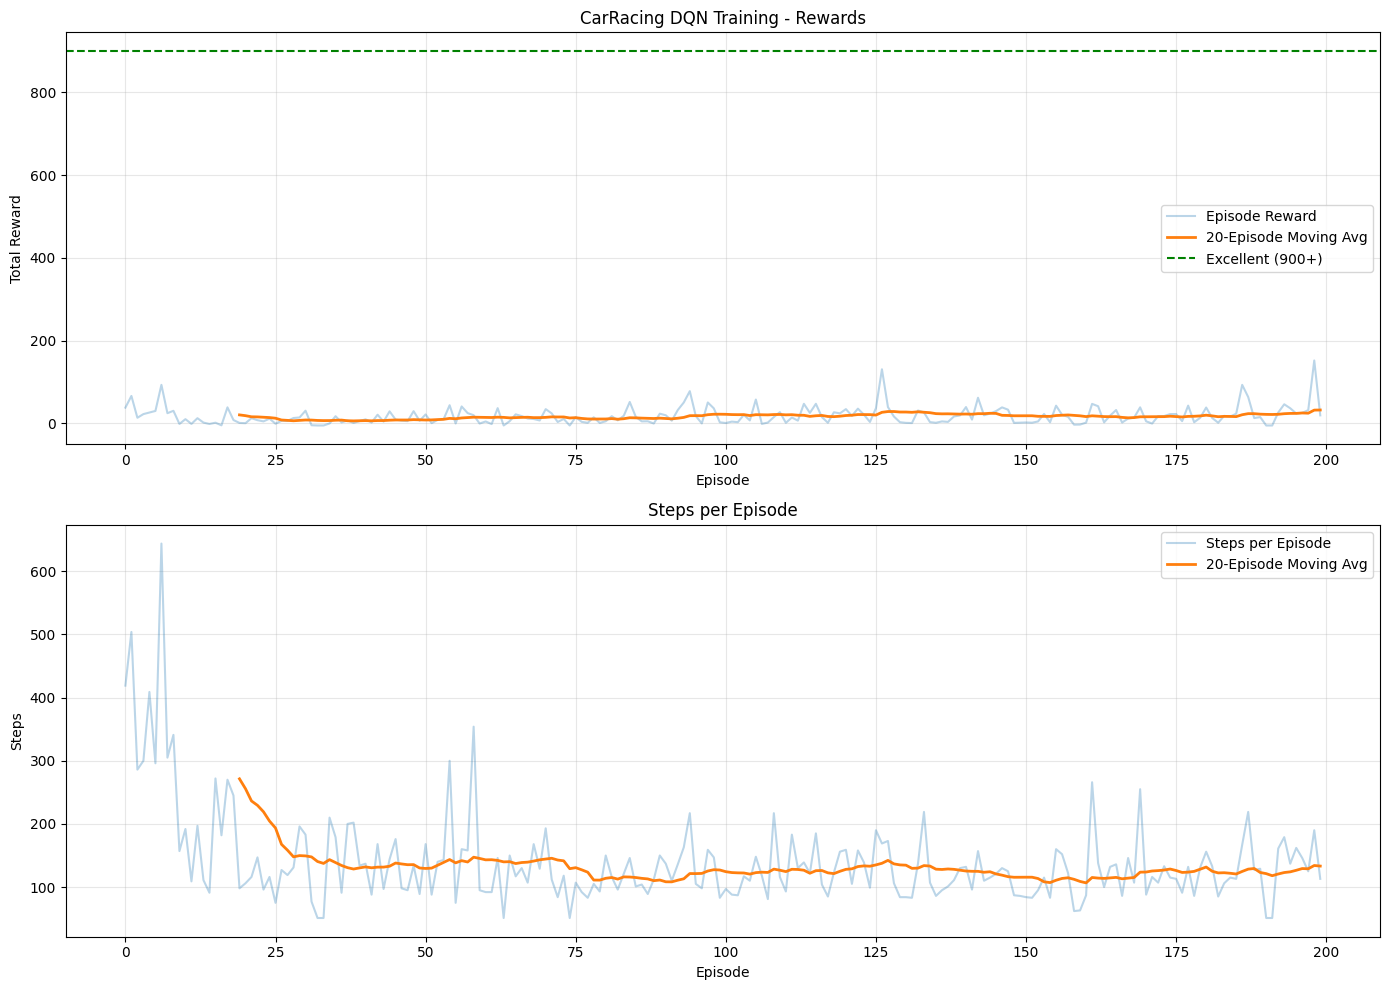


Final Statistics:
  Best reward: 152.1
  Average reward (last 20): 32.4
  Average steps (last 20): 133.2


In [37]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rewards
axes[0].plot(car_rewards, alpha=0.3, label='Episode Reward')
window = 20
if len(car_rewards) >= window:
    moving_avg = np.convolve(car_rewards, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(car_rewards)), moving_avg,
                 linewidth=2, label=f'{window}-Episode Moving Avg')
axes[0].axhline(y=900, color='green', linestyle='--', label='Excellent (900+)')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Reward')
axes[0].set_title('CarRacing DQN Training - Rewards')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Steps
axes[1].plot(car_steps, alpha=0.3, label='Steps per Episode')
if len(car_steps) >= window:
    steps_ma = np.convolve(car_steps, np.ones(window)/window, mode='valid')
    axes[1].plot(range(window-1, len(car_steps)), steps_ma,
                 linewidth=2, label=f'{window}-Episode Moving Avg')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Steps')
axes[1].set_title('Steps per Episode')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Statistics:")
print(f"  Best reward: {max(car_rewards):.1f}")
print(f"  Average reward (last 20): {np.mean(car_rewards[-20:]):.1f}")
print(f"  Average steps (last 20): {np.mean(car_steps[-20:]):.1f}")

Testing agent...
Test Episode 1: Reward = -94.0, Steps = 939


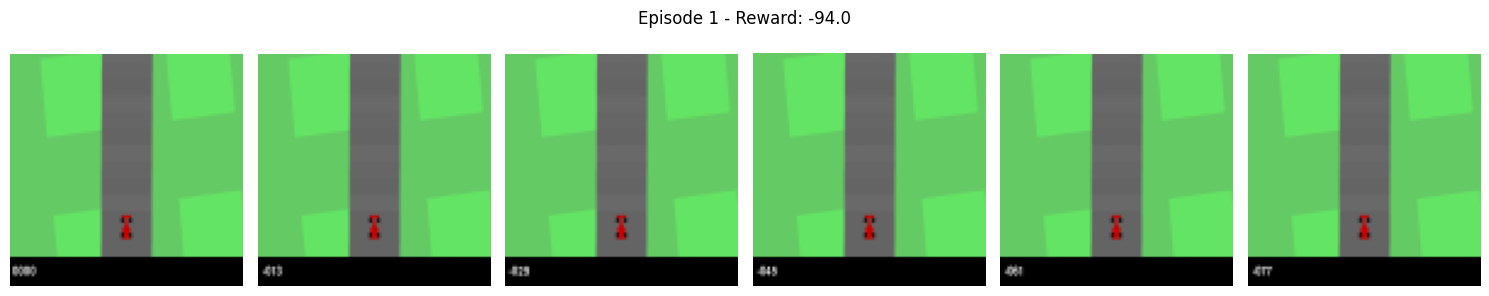

Test Episode 2: Reward = -94.0, Steps = 939


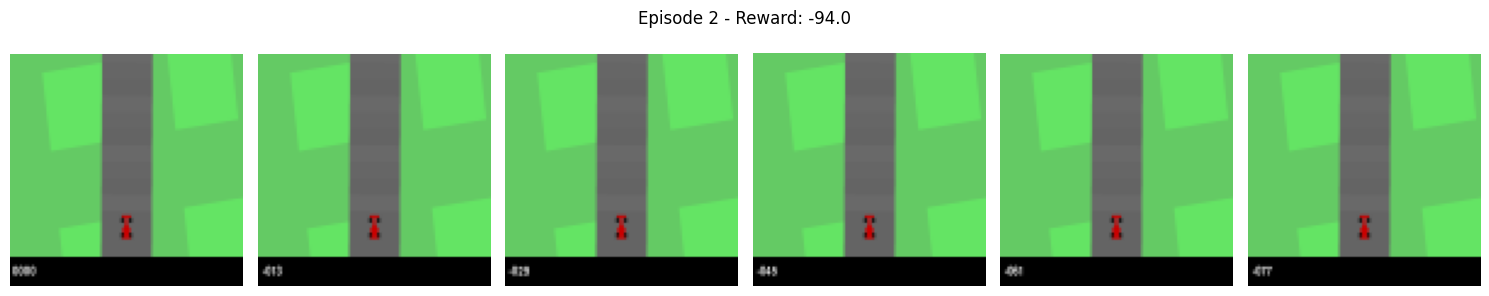

In [40]:
def test_agent_visual(agent, episodes=3, stack_size=4, skip_frames=60):
    """Test agent with visualization"""
    try:
        import gymnasium
        env = gymnasium.make('CarRacing-v3', render_mode='rgb_array') # Use v3
    except:
        env = gym.make('CarRacing-v3') # Fallback to v3

    for episode in range(episodes):
        reset_result = env.reset()
        frame = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        # Skip initial frames
        for _ in range(skip_frames):
            step_result = env.step(np.array([0, 0, 0])) # Ensure action is numpy array
            frame = step_result[0]

        # Initialize
        stacked_frames = deque(maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, frame, True, stack_size)

        episode_reward = 0
        frames_to_show = []

        for step in range(1000):
            action_idx = agent.select_action(state, training=False)
            # Convert action list to numpy array
            action = np.array(ACTIONS[action_idx])

            step_result = env.step(action)
            if len(step_result) == 5:
                next_frame, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_frame, reward, done, _ = step_result

            # Save some frames for visualization
            if step % 20 == 0:
                frames_to_show.append(next_frame)

            next_state, stacked_frames = stack_frames(
                stacked_frames, next_frame, False, stack_size
            )

            episode_reward += reward
            state = next_state

            if done:
                break

        print(f"Test Episode {episode+1}: Reward = {episode_reward:.1f}, Steps = {step}")

        # Show some frames
        if frames_to_show:
            n_frames = min(6, len(frames_to_show))
            fig, axes = plt.subplots(1, n_frames, figsize=(15, 3))
            for i in range(n_frames):
                idx = i * len(frames_to_show) // n_frames
                axes[i].imshow(frames_to_show[idx])
                axes[i].axis('off')
            plt.suptitle(f'Episode {episode+1} - Reward: {episode_reward:.1f}')
            plt.tight_layout()
            plt.show()

    env.close()

print("Testing agent...")
test_agent_visual(car_agent, episodes=2)

In [41]:
print("=" * 70)
print("CARRACING DQN SUMMARY")
print("=" * 70)
print("""
Key Implementation Details:
1. Frame Preprocessing:
   - Crop bottom 12 pixels (remove indicators)
   - Convert to grayscale (84x84)
   - Normalize to [0, 1]

2. Frame Stacking:
   - Stack 4 consecutive frames
   - Captures motion information
   - Input shape: (84, 84, 4)

3. CNN Architecture:
   - Conv2D: 32 filters (8x8), stride 4
   - Conv2D: 64 filters (4x4), stride 2
   - Conv2D: 64 filters (3x3), stride 1
   - Flatten + Dense(512) + Dense(9)

4. Action Space (9 discrete actions):
   - Left/Right turns
   - Gas/Brake
   - Combined actions (turn + gas)

5. Training Optimizations:
   - Skip first 60 frames (zoom animation)
   - Train every 4 steps (faster)
   - Early termination on negative rewards
   - Small batch size (32) for stability

Expected Performance:
- Initial episodes: -50 to +100 (learning track)
- Mid training: +200 to +500 (completing track slowly)
- Good performance: +700 to +900 (fast completion)
- Excellent: +900+ (optimal racing)

Training typically takes:
- 100 episodes: Basic track navigation
- 200 episodes: Consistent completion
- 500+ episodes: Near-optimal racing

This is the hardest task - learning from raw pixels!
""")
print("=" * 70)

CARRACING DQN SUMMARY

Key Implementation Details:
1. Frame Preprocessing:
   - Crop bottom 12 pixels (remove indicators)
   - Convert to grayscale (84x84)
   - Normalize to [0, 1]

2. Frame Stacking:
   - Stack 4 consecutive frames
   - Captures motion information
   - Input shape: (84, 84, 4)

3. CNN Architecture:
   - Conv2D: 32 filters (8x8), stride 4
   - Conv2D: 64 filters (4x4), stride 2
   - Conv2D: 64 filters (3x3), stride 1
   - Flatten + Dense(512) + Dense(9)

4. Action Space (9 discrete actions):
   - Left/Right turns
   - Gas/Brake
   - Combined actions (turn + gas)

5. Training Optimizations:
   - Skip first 60 frames (zoom animation)
   - Train every 4 steps (faster)
   - Early termination on negative rewards
   - Small batch size (32) for stability

Expected Performance:
- Initial episodes: -50 to +100 (learning track)
- Mid training: +200 to +500 (completing track slowly)
- Good performance: +700 to +900 (fast completion)
- Excellent: +900+ (optimal racing)

Training t

QUICK TEST MODE (50 episodes)
✓ Using CarRacing-v3 (Gymnasium)
Training CarRacing DQN
Input shape: (84, 84, 4), Actions: 9
Skip frames: 60, Stack size: 4
----------------------------------------------------------------------
Ep  10/50 | R:   14.0 | Avg10:   10.7 | Steps:  189 | ε: 0.916
Ep  20/50 | R:    7.4 | Avg10:    5.6 | Steps:  106 | ε: 0.855
Ep  30/50 | R:    6.6 | Avg10:    8.6 | Steps:  170 | ε: 0.787
Ep  40/50 | R:    2.0 | Avg10:   13.5 | Steps:   81 | ε: 0.728
Ep  50/50 | R:   -1.6 | Avg10:    3.3 | Steps:   81 | ε: 0.691
----------------------------------------------------------------------
Training complete!
Final avg reward (last 20): 8.4


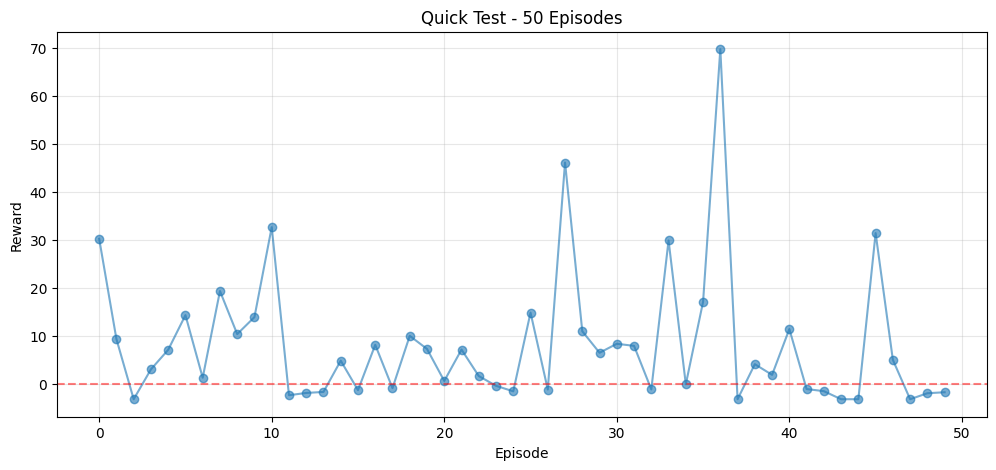

Average reward: 8.3


In [42]:

print("=" * 70)
print("QUICK TEST MODE (50 episodes)")
print("=" * 70)

quick_agent, quick_rewards, quick_steps = train_car_racing(
    episodes=50,
    max_steps=800,
    skip_frames=60,
    stack_size=4,
    train_frequency=8,  # Train less often
    negative_reward_threshold=30
)

plt.figure(figsize=(12, 5))
plt.plot(quick_rewards, marker='o', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Quick Test - 50 Episodes')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average reward: {np.mean(quick_rewards):.1f}")

The DQN agent was trained on CarRacing-v3 using image input (84x84 grayscale, 4-frame stack) and a 9-action discrete control set covering steering, acceleration, braking, and combined steering-with-gas actions. Over 200 training episodes, the model showed gradual improvement: early rewards remained close to zero, mid-training stabilized between 10 and 30, and late-stage performance occasionally reached higher values with a maximum reward of about 152. The final moving average over the last 20 episodes was approximately 32.4, indicating that the agent learned basic control but still lacked consistent track completion or long-term stability. Two test evaluation episodes both resulted in rewards of -94, showing that the policy does not generalize well under low-exploration conditions. A shorter 50-episode quick training produced even lower performance (average reward about 8.4), confirming that the environment requires many more episodes to train effectively. In summary, the DQN approach is partially successful at learning movement and basic navigation but needs substantially more training time (typically 500+ episodes) to achieve reliable lap completion and competitive racing results.